In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial
from torchvision.utils import make_grid
from shell.utils.oodloss import OODSeparationLoss
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

from shell.fleet.network import *
logging.basicConfig(level=logging.INFO)

In [3]:
experiment_folder = "heuristic_experiment_results"
experiment_name = "heuristic_budget_20_enforce_balance_True_mem_400"
dataset = "combined"
algo = "modular"

use_contrastive = False
num_trains_per_class = 64 if dataset != "cifar100" else 256
seed = 0
num_tasks = 10
parallel = False
task_id = 4

In [4]:
def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    cfg.sharing_strategy['enforce_balance'] = False
    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

In [5]:
save_dir = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)

fleet = setup_fleet(save_dir, task_id=task_id, parallel=False, modify_cfg=modify_cfg)
fleet.change_save_dir('debug_heuristic_data')

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (1872, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (1992, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28) (100, 1, 28, 28) (1940, 1, 28, 28)


INFO:root:task 3 :(128, 1, 28, 28) (100, 1, 28, 28) (1992, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28) (100, 1, 28, 28) (1954, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'combined', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5, 'no_sparse_basis': True}, 'sharing_strategy': {'name': 'heuristic_data', 'num_coms_per_round': 2, 'budget': 20, 'enforce_balance': True, 'shared_memory_size': 400, 'comm_freq': 16, 'query_task_mode': 'current', 'pre_or_post_comm': 'post', 'sync_base': True, 'remove_ood_neighbors': True, 'min_task': 4}, 'seed': 0, 'algo': 'modular', 'job_name': 'combined_modular_numtrain_64', 'num_agents': 20, 'root_save_dir': 'heuristic_experiment_results/heuristic_budget_20_enforce_balance_True_mem_400', 'parallel': True, 'num_init_tasks': 4, 'overwrite': False, 'topology': 'fully_connected', 'edge_drop_prob': 0.0, 

INFO:root:task 5 :(128, 1, 28, 28) (100, 1, 28, 28) (2115, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28) (100, 1, 28, 28) (1901, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28) (100, 1, 28, 28) (1940, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28) (100, 1, 28, 28) (1989, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28) (100, 1, 28, 28) (1990, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28) (100, 1, 28, 28) (2000, 1, 28, 28)
INFO:root:task 8 :(128

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>
Setting seed 69420000
Setting seed 0
Setting seed 1000
Setting seed 2000
Setting seed 3000
Setting seed 4000
Setting seed 5000
Setting seed 6000
Setting seed 7000
Setting seed 8000
Setting seed 9000
Setting seed 10000
Setting seed 11000
Setting seed 12000
Setting seed 13000
Setting seed 14000
Setting seed 15000
Setting seed 16000
Setting seed 17000
Setting seed 18000
Setting seed 19000


In [6]:
for agent in fleet.agents:
    print(agent.node_id, {t: len(r) for t, r in agent.agent.shared_replay_buffers.items()})
    # Xt, yt, _ = agent.agent.shared_replay_buffers[task_id].get_tensors()
    # for c in yt.unique():
    #     print('\t', c.item(), Xt[yt == c].shape)

0 {}
1 {}
2 {}
3 {}
4 {}
5 {}
6 {}
7 {}
8 {}
9 {}
10 {}
11 {}
12 {}
13 {}
14 {}
15 {}
16 {}
17 {}
18 {}
19 {}


In [7]:
for agent in fleet.agents:
    print(agent.node_id, agent.dataset.name, agent.dataset.class_sequence)

0 mnist [5 0 5 7 4 1 3 4 8 0 1 0 5 9 6 4 9 0 3 0]
1 kmnist [5 0 5 7 4 1 3 4 5 0 3 6 2 7 6 7 6 1 0 5]
2 fashionmnist [5 0 5 7 4 1 3 4 6 1 6 4 5 7 8 0 2 3 0 3]
3 mnist [5 0 5 7 4 1 3 4 4 5 9 3 0 6 9 1 3 1 7 9]
4 kmnist [5 0 5 7 4 1 3 4 2 1 7 6 8 6 1 8 6 4 9 8]
5 fashionmnist [5 0 5 7 4 1 3 4 4 9 3 2 2 9 6 0 5 9 7 2]
6 mnist [5 0 5 7 4 1 3 4 4 6 1 3 3 1 4 1 9 2 6 2]
7 kmnist [5 0 5 7 4 1 3 4 5 0 7 2 7 8 6 1 6 0 0 6]
8 fashionmnist [5 0 5 7 4 1 3 4 6 4 3 2 4 6 7 4 9 0 3 1]
9 mnist [5 0 5 7 4 1 3 4 8 0 3 7 8 6 4 2 8 3 8 0]
10 kmnist [5 0 5 7 4 1 3 4 4 6 1 3 2 8 8 5 4 6 6 7]
11 fashionmnist [5 0 5 7 4 1 3 4 5 2 5 3 8 6 2 8 8 0 1 0]
12 mnist [5 0 5 7 4 1 3 4 9 3 7 4 6 9 4 9 0 6 5 3]
13 kmnist [5 0 5 7 4 1 3 4 0 1 2 7 1 4 5 1 5 7 9 0]
14 fashionmnist [5 0 5 7 4 1 3 4 3 4 0 9 6 8 4 3 5 0 3 4]
15 mnist [5 0 5 7 4 1 3 4 4 7 8 5 5 2 3 1 0 5 8 9]
16 kmnist [5 0 5 7 4 1 3 4 5 9 0 7 1 6 9 0 6 1 2 9]
17 fashionmnist [5 0 5 7 4 1 3 4 7 6 2 1 5 9 9 6 7 0 5 2]
18 mnist [5 0 5 7 4 1 3 4 2 7 2 7 1 3 3 0 0 

In [8]:
"""
For agent 4: kmnist class (2, 1)
1 comes from agent 1
"""

'\nFor agent 4: kmnist class (2, 1)\n1 comes from agent 1\n'

In [9]:
fleet.communicate(task_id=task_id, end_epoch=None, comm_freq=None, num_epochs=None)

In [10]:
for agent in fleet.agents:
    print(agent.node_id, {t: len(r) for t, r in agent.agent.shared_replay_buffers.items()})
    if len(agent.agent.shared_replay_buffers[task_id]) == 0:
        print('\t !!!NO DATA!!!!')
        continue
    Xt, yt, _ = agent.agent.shared_replay_buffers[task_id].get_tensors()
    for c in yt.unique():
        print('\t', c.item(), Xt[yt == c].shape)

0 {0: 10, 1: 0, 2: 0, 3: 0, 4: 20}
	 0 torch.Size([10, 1, 28, 28])
	 1 torch.Size([10, 1, 28, 28])
1 {0: 40, 1: 20, 2: 0, 3: 0, 4: 40}
	 0 torch.Size([20, 1, 28, 28])
	 1 torch.Size([20, 1, 28, 28])
2 {0: 0, 1: 0, 2: 0, 3: 0, 4: 20}
	 0 torch.Size([20, 1, 28, 28])
3 {0: 0, 1: 0, 2: 20, 3: 20, 4: 20}
	 0 torch.Size([20, 1, 28, 28])
4 {0: 0, 1: 0, 2: 40, 3: 0, 4: 40}
	 1 torch.Size([40, 1, 28, 28])
5 {0: 0, 1: 0, 2: 40, 3: 40, 4: 40}
	 0 torch.Size([40, 1, 28, 28])
6 {0: 0, 1: 0, 2: 40, 3: 40, 4: 40}
	 0 torch.Size([40, 1, 28, 28])
7 {0: 40, 1: 20, 2: 0, 3: 0, 4: 40}
	 0 torch.Size([20, 1, 28, 28])
	 1 torch.Size([20, 1, 28, 28])
8 {0: 0, 1: 0, 2: 40, 3: 40, 4: 60}
	 0 torch.Size([20, 1, 28, 28])
	 1 torch.Size([40, 1, 28, 28])
9 {0: 10, 1: 0, 2: 0, 3: 0, 4: 20}
	 0 torch.Size([10, 1, 28, 28])
	 1 torch.Size([10, 1, 28, 28])
10 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
	 !!!NO DATA!!!!
11 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
	 !!!NO DATA!!!!
12 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
	 !!!NO DATA!!!!
13 {0: 20, 1

In [11]:
fleet.remove_ood_neighbors

True

In [12]:
agent.neighbors

{1: <shell.fleet.data.heuristic.HeuristicDataAgent at 0x7f0f8bf58cd0>,
 4: <shell.fleet.data.heuristic.HeuristicDataAgent at 0x7f0f8bf98f40>,
 7: <shell.fleet.data.heuristic.HeuristicDataAgent at 0x7f0f8bfd9180>,
 10: <shell.fleet.data.heuristic.HeuristicDataAgent at 0x7f0f8c00d390>,
 13: <shell.fleet.data.heuristic.HeuristicDataAgent at 0x7f0f88d355a0>,
 16: <shell.fleet.data.heuristic.HeuristicDataAgent at 0x7f0f88d757b0>}

In [13]:
agent.dataset.name

'kmnist'

In [14]:
agent = fleet.agents[5]
Xt, yt, _ = agent.agent.shared_replay_buffers[task_id].get_tensors()

In [15]:
agent.min_task

4

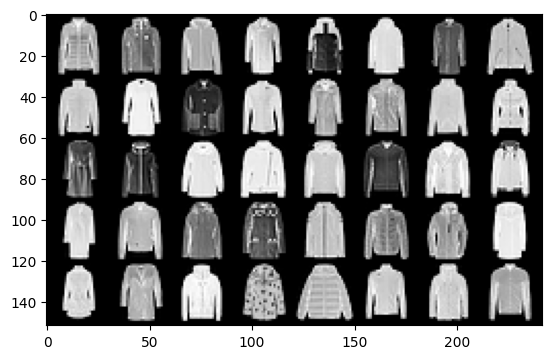

In [16]:
plt.imshow(make_grid(Xt).permute(1, 2, 0));